   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 59.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.29.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.0.2 which is incompatible.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.0.2 which is incompatible.
Header added and data saved to 'heart_disease_data.csv'
               age       sex        cp  trestbps      chol       fbs  \
age       1.000000 -0.097542  0.104139  0.284946  0.208950  0.118530   
sex      -0.097542  1.000000  0.010084 -0.064456 -0.199915  0.047862   
cp        0.104139  0.010084  1.000000 -0.036077  0.072319 -0.039975   
trestbps  0.284946 -0.06

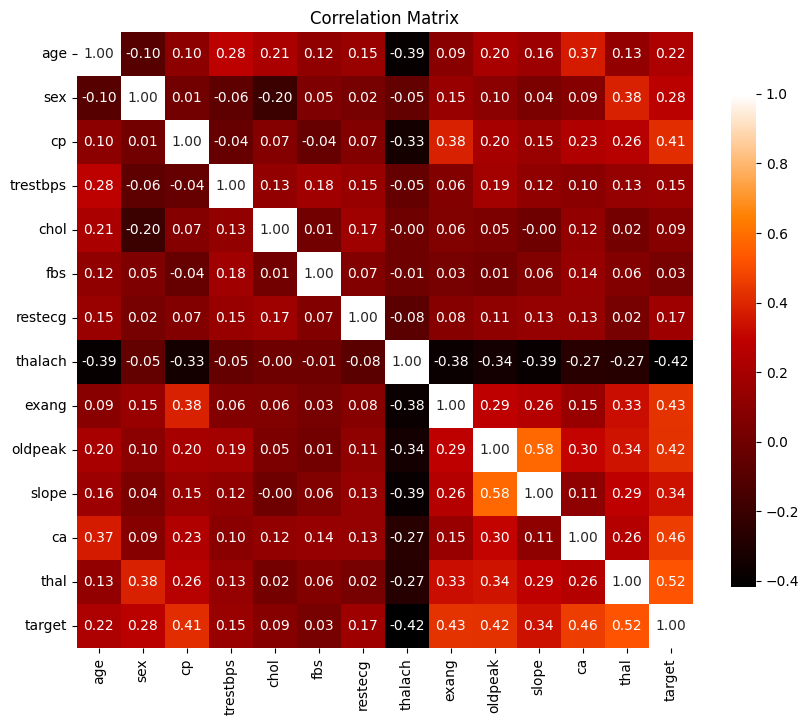


=== Stacking Classifier (Random Forest + XGBoost + Logistic Regression) ===
Accuracy: 88.52%
Confusion Matrix:

ROC AUC: 0.94
Sensitivity: 84.38%
Specificity: 93.10%


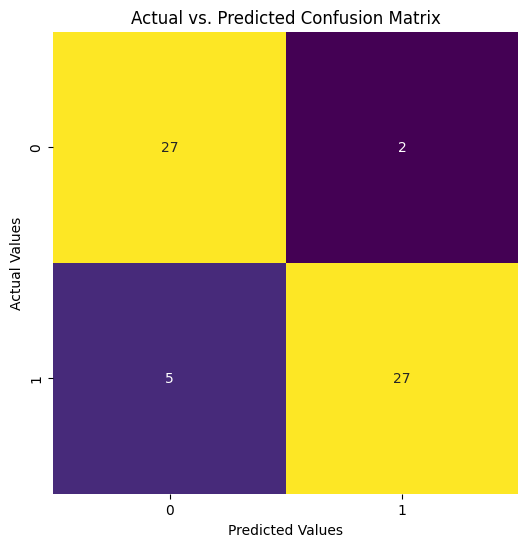

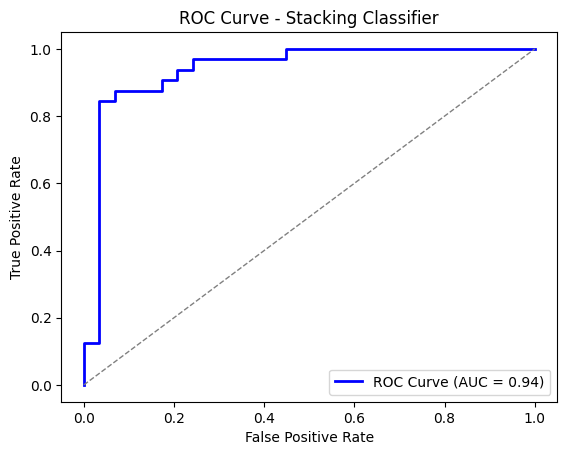

In [1]:
# Import necessary libraries
!pip install xgboost
!pip install scikit-learn==1.0.2

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRFClassifier
import matplotlib.pyplot as plt

# Define the column names
header = [
    "age",
    "sex",
    "cp",
    "trestbps",
    "chol",
    "fbs",
    "restecg",
    "thalach",
    "exang",
    "oldpeak",
    "slope",
    "ca",
    "thal",
    "target"
]

# Load the dataset without a header
data = pd.read_csv('processed.cleveland.data', header=None)

# Assign the header to the DataFrame
data.columns = header

# Save the updated DataFrame to a new CSV file
data.to_csv('heart_disease_data.csv', index=False)

print("Header added and data saved to 'heart_disease_data.csv'")

# Load the updated CSV file
df = pd.read_csv('heart_disease_data.csv')

# Compute the correlation matrix
correlation_matrix = df.corr()

# Print the correlation matrix
print(correlation_matrix)

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create a heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='gist_heat', square=True, cbar_kws={"shrink": .8})

# Set the title
plt.title('Correlation Matrix')

# Show the plot
plt.show()


# # Assuming the last column is the target variable (heart disease presence)
X = df.iloc[:, :-1]  # Features (all columns except the last)
y = df['target']     # Target variable (last column renamed to 'target')

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize base models
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_model = XGBRFClassifier(n_estimators=100, random_state=42)

# Initialize meta-model
meta_model = LogisticRegression()

# Create Stacking Classifier
stacking_model = StackingClassifier(
    estimators=[
        ('random_forest', rf_model),
        ('xgboost', xgb_model)
    ],
    final_estimator=meta_model,
    cv=5
)

# Train the stacking model
stacking_model.fit(X_train, y_train)

# Make predictions
y_pred_stacking = stacking_model.predict(X_test)
y_pred_proba_stacking = stacking_model.predict_proba(X_test)[:, 1]

# Evaluate the stacking model
accuracy_stacking = accuracy_score(y_test, y_pred_stacking)
conf_matrix_stacking = confusion_matrix(y_test, y_pred_stacking)
roc_auc_stacking = roc_auc_score(y_test, y_pred_proba_stacking)

# Print evaluation metrics
print("\n=== Stacking Classifier (Random Forest + XGBoost + Logistic Regression) ===")
print(f"Accuracy: {accuracy_stacking * 100:.2f}%")
print(f"Confusion Matrix:\n")
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_stacking, annot=True, fmt="d", cmap="viridis", cbar=False)

# Menambahkan label pada heatmap
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.title("Actual vs. Predicted Confusion Matrix")
print(f"ROC AUC: {roc_auc_stacking:.2f}")

# Calculate Sensitivity and Specificity
tn, fp, fn, tp = conf_matrix_stacking.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"Sensitivity: {sensitivity * 100:.2f}%")
print(f"Specificity: {specificity * 100:.2f}%")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_stacking)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc_stacking:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Stacking Classifier')
plt.legend(loc='lower right')
plt.show()


In [ ]:
# Extract confusion matrix values
tn, fp, fn, tp = conf_matrix_stacking.ravel()

# Calculate Sensitivity, Specificity, and Accuracy
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
accuracy = accuracy_stacking

# Print detailed evaluation metrics
print("\n=== Detailed Evaluation Metrics ===")
print(f"True Positive (TP): {tp}")
print(f"True Negative (TN): {tn}")
print(f"False Positive (FP): {fp}")
print(f"False Negative (FN): {fn}")
print(f"Sensitivity (Recall): {sensitivity * 100:.2f}%")
print(f"Specificity: {specificity * 100:.2f}%")
print(f"Accuracy: {accuracy * 100:.2f}%")




=== Detailed Evaluation Metrics ===
True Positive (TP): 27
True Negative (TN): 27
False Positive (FP): 2
False Negative (FN): 5
Sensitivity (Recall): 84.38%
Specificity: 93.10%
Accuracy: 88.52%
